##  Imports 

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

##  1. CSV setup 

In [88]:
# Load files
temp_df = pd.read_csv('../test_csv/motor_temp_high.csv')
power_df = pd.read_csv('../test_csv/motor_power_high.csv')
rpm_df   = pd.read_csv('../test_csv/motor_rpm_high.csv')
vib_df   = pd.read_csv('../test_csv/motor_viberation_high.csv')

# Parse timestamps
for df in [temp_df, power_df, rpm_df, vib_df]:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Rename columns
temp_df = temp_df.rename(columns={'feature_0': 'temperature'})
power_df = power_df.rename(columns={'feature_0': 'power'})
rpm_df = rpm_df.rename(columns={'feature_0': 'rpm'})
vib_df = vib_df.rename(columns={'feature_0': 'vibration'})

# Merge on timestamp
df_merged = temp_df[['timestamp', 'state', 'temperature']]\
    .merge(power_df[['timestamp', 'power']], on='timestamp')\
    .merge(rpm_df[['timestamp', 'rpm']], on='timestamp')\
    .merge(vib_df[['timestamp', 'vibration']], on='timestamp')

df_merged['csv_index'] = df_merged.index

# 2️⃣ Filter for 'run' state
df_run = df_merged[df_merged['state'] == 'run'].copy()
feature_cols = ['temperature', 'power', 'rpm', 'vibration']
index_ref = df_run['csv_index'].values

In [89]:
# 3️⃣ Normalize
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_run[feature_cols])

# 4️⃣ Create sequences
def create_multisensor_sequences(data, index_ref, window=20):
    sequences, start_indices, end_indices = [], [], []
    for i in range(len(data) - window):
        sequences.append(data[i:i+window])
        start_indices.append(index_ref[i])
        end_indices.append(index_ref[i + window - 1])
    return np.array(sequences), start_indices, end_indices

seq_len = 20
X_all, start_all, end_all = create_multisensor_sequences(scaled_features, index_ref, seq_len)

# 5️⃣ Split into clean training and test (based on csv_index)
cutoff_index = 800  # Choose an early window (assumed clean)
X_train = X_all[:cutoff_index]
X_test  = X_all[cutoff_index:]
start_train = start_all[:cutoff_index]
end_train   = end_all[:cutoff_index]
start_test  = start_all[cutoff_index:]
end_test    = end_all[cutoff_index:]

print(f"✅ Final split:")
print(f"Train sequences: {X_train.shape}, from {start_train[0]} → {end_train[-1]}")
print(f"Test  sequences: {X_test.shape}, from {start_test[0]} → {end_test[-1]}")


✅ Final split:
Train sequences: (800, 20, 4), from 30720 → 31538
Test  sequences: (302284, 20, 4), from 31520 → 368382


Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2226
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0736
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0510
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0427
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0380
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0362
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0347
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0349
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0342
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336
9447/9447 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step

📉 Anomaly threshold (95th percentile): 0.177654
🔎 Row 0 | error=0.133358 | csv_index=31539 | timestamp=2025-04-07T02:03:00.000000000
🔎 Row 1 | error=0.132195 | csv_index=31540 | timestamp=2025-04-07T02:03:00.000000000
🔎 Row 2 | error=0.131025 | csv_index=31541 | timestamp=2025-04-07T02:03:00.000000000
🔎 Row 3 | er

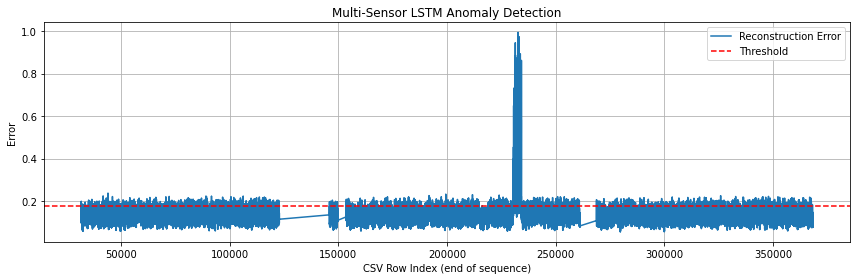

In [90]:
# 6️⃣ Train LSTM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_all.shape[1], X_all.shape[2]), return_sequences=False),
    RepeatVector(X_all.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_all.shape[2]))
])
model.compile(optimizer=Adam(1e-3), loss='mse')
model.fit(X_train, X_train, epochs=10, batch_size=32, verbose=1)

# 7️⃣ Predict & Calculate Error
X_pred = model.predict(X_test)
errors = np.mean(np.abs(X_pred - X_test), axis=(1, 2))
threshold = np.percentile(errors, 95)

print(f"\n📉 Anomaly threshold (95th percentile): {threshold:.6f}")
for i in range(5):
    print(f"🔎 Row {i} | error={errors[i]:.6f} | csv_index={end_test[i]} | timestamp={df_run.loc[df_run['csv_index'] == end_test[i], 'timestamp'].values[0]}")

# 8️⃣ Plot
plt.figure(figsize=(12, 4))
plt.plot(end_test, errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Multi-Sensor LSTM Anomaly Detection")
plt.xlabel("CSV Row Index (end of sequence)")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
